# **Police classifier for 'Spotlight'**

Based on code by Jordan Lin & Jackson Steele for *QWER Hacks $\times$ ACM AI*

Originally we were modelling with Tensor Flow, but shifted to using the Pycharm code because of python version issues on our teammates' computers.

Cooper Bedin & Cedar Brown


# Import packages

In [ ]:
# numpy: the library that deals with linear algebra calculations
import numpy as np
# (py)torch: our machine learning library!
import torch
import torch.nn.functional as F
from torch import nn, optim, utils
from torchvision import datasets, transforms
# matplotlib: the library for making plots & displaying images
import matplotlib.pyplot as plt
# tqdm: the library for displaying progress bars
from tqdm.notebook import tqdm

In [ ]:
# use GPU is GPU (CUDA) is available, use CPU otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


## Data

Currently using CIFAR-10, which comprises of $50000$ training images and $10000$ testing images with dimensions $32 \times 32 \times 3$ (square image $32$ in width, $3$ for the RGB channels).

We used 'cars' as a proxy for police, and have made it into a binary classifier that classifies things as car/non-car.

Ideally, would make our own training set that classifies police cars from other pictures.


In [ ]:
# pre-process images
transform = transforms.Compose([transforms.ToTensor()])  # convert image to pytorch tensor
target_transform = transforms.Lambda(lambda x: int(x == 1)) #converts it to binary classification
# download images and create PyTorch Dataset & DataLoader objects
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform, target_transform=target_transform)
train_loader = utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform, target_transform=target_transform)
test_loader = utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(train_dataset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Target transform: Lambda()


In [ ]:
classes = ['non-car', 'car']

In [ ]:
# data augmentation to prevent overfitting
data_augmentation = nn.Sequential(transforms.RandomHorizontalFlip(),
                                  transforms.RandomCrop((32, 32), padding=(4, 4)))
data_augmentation = torch.jit.script(data_augmentation)  # scriptify to make augmentation run faster

In [ ]:
class CNN(nn.Module):

    def __init__(self):
        """Initialize the CNN network and define its layers"""
        super().__init__()

        # there are many different ways of defining a PyTorch model, nn.Sequential is just the most
        # convenient one as everything is in one callable 'thing' and executes in sequence
        self.network = nn.Sequential(
            # layer 1: b x 3 x 32 x 32 -> b x 32 x 16 x 16 (format: channel x width x height)
            nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # layer 2: b x 32 x 16 x 16 -> b x 64 x 8 x 8
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # layer 3: b x 64 x 8 x 8 -> b x 64 x 4 x 4
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # flatten and output fully-connected layer
            nn.Flatten(),  # b x 64 x 4 x 4 -> b x (64 * 4 * 4)
            nn.Linear(64 * 4 * 4, 2))#2 here instead of 10 bc binary classification
        # ... however, you can do something like:
        # self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        # self.relu1 = nn.ReLU()
        # sekf.batch_norm1 = nn.BatchNorm2d(32)
        # ...
        # and then in the forward function sequentially pass x through these class variables
    
    def forward(self, x):
        """Pass input x through the network to obtain an output"""
        output = self.network(x)
        return output

    def size(self):
        """Count the number of parameters (i.e., size of weights) in the network"""
        parameters = self.parameters()
        size = 0
        for parameter in parameters:
            size += np.prod(parameter.shape)
        return size

In [ ]:
network = CNN()
network.to(device)  # if we are using GPU, put the network weights on the GPU

CNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1024, out_features=2, bias=True)
  )
)

In [ ]:
print(f"Network size: {network.size()}")

Network size: 68426


## Criterion and Optimizer


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(network.parameters(), lr=0.0003, weight_decay=1e-5)

## Training

As per the code we based this on, we are not using validation set here and just evaluating on the testing set, but we would with more time.

In [ ]:
@torch.no_grad()  # we don't want to compute gradients here!
def evaluate(loader, network, criterion):
    network.eval()  # put network into evaluation mode (mostly for batch normalization)
    losses = []
    accuracies = []
    for inputs, labels in loader:
        inputs = inputs.to(device)  # put inputs and labels on GPU (if it is available)
        labels = labels.to(device)
        outputs = network(inputs)  # pass inputs through network to get outputs
        loss = criterion(outputs, labels)  # evaluate outputs with criterion to get loss
        accuracy = (torch.max(outputs, dim=1)[1] == labels).to(torch.float32).mean()  # accuracy
        losses.append(loss.cpu().numpy())
        accuracies.append(accuracy.cpu().numpy())
    return np.mean(losses), np.mean(accuracies)

In [ ]:
epoch_max = 32  # you can increase this if you want (takes longer, but accuracy will be higher)
results = {"train losses": [], "train accuracies": [], "test losses": [], "test accuracies": []}

for epoch in tqdm(range(epoch_max)):
    for inputs, labels in tqdm(train_loader, leave=False):
        inputs = inputs.to(device)  # put inputs and labels on GPU (if it is available)
        labels = labels.to(device)
        inputs = data_augmentation(inputs)  # perform data augmentation on inputs
        network.train()  # put network into training mode (mostly for batch normalization)
        optimizer.zero_grad()  # zero-out gradients
        outputs = network(inputs)  # pass inputs through network to get outputs
        loss = criterion(outputs, labels)  # evaluate outputs bwith criterion to get loss
        loss.backward()  # backpropagate through loss to compute gradients (loss w.r.t. weights)
        optimizer.step()  # use gradients to perform optimization (e.g., NAdam)
    
    # after every epoch, evaluate results on the entire training & testing set (slow)
    train_loss, train_accuracy = evaluate(train_loader, network, criterion)
    test_loss, test_accuracy = evaluate(test_loader, network, criterion)
    # store results
    results["train losses"].append(train_loss)
    results["train accuracies"].append(train_accuracy)
    results["test losses"].append(test_loss)
    results["test accuracies"].append(test_accuracy)
    # print results so we can see how the network is doing
    result = f"{('[' + str(epoch + 1) + ']'):5s}   "\
                f"Train: {str(train_accuracy * 100):.6}% ({str(train_loss):.6})   "\
                f"Test: {str(test_accuracy * 100):.6}% ({str(test_loss):.6})"
    tqdm.write(result)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

[1]     Train: 92.614% (0.1817)   Test: 92.385% (0.1802)


  0%|          | 0/391 [00:00<?, ?it/s]

[2]     Train: 92.712% (0.1745)   Test: 92.405% (0.1755)


  0%|          | 0/391 [00:00<?, ?it/s]

[3]     Train: 93.077% (0.1686)   Test: 92.820% (0.1688)


  0%|          | 0/391 [00:00<?, ?it/s]

[4]     Train: 94.110% (0.1439)   Test: 94.036% (0.1446)


  0%|          | 0/391 [00:00<?, ?it/s]

[5]     Train: 93.899% (0.1614)   Test: 93.690% (0.1674)


  0%|          | 0/391 [00:00<?, ?it/s]

[6]     Train: 93.912% (0.1609)   Test: 93.591% (0.1678)


  0%|          | 0/391 [00:00<?, ?it/s]

[7]     Train: 94.966% (0.1271)   Test: 94.748% (0.1315)


  0%|          | 0/391 [00:00<?, ?it/s]

[8]     Train: 95.316% (0.1198)   Test: 94.748% (0.1246)


  0%|          | 0/391 [00:00<?, ?it/s]

[9]     Train: 95.268% (0.1203)   Test: 94.649% (0.1314)


  0%|          | 0/391 [00:00<?, ?it/s]

[10]    Train: 95.306% (0.1219)   Test: 94.966% (0.1283)


  0%|          | 0/391 [00:00<?, ?it/s]

[11]    Train: 95.921% (0.1059)   Test: 95.510% (0.1142)


  0%|          | 0/391 [00:00<?, ?it/s]

[12]    Train: 95.988% (0.1029)   Test: 95.530% (0.1144)


  0%|          | 0/391 [00:00<?, ?it/s]

[13]    Train: 95.764% (0.1101)   Test: 95.272% (0.1167)


  0%|          | 0/391 [00:00<?, ?it/s]

[14]    Train: 95.673% (0.1162)   Test: 95.371% (0.1261)


  0%|          | 0/391 [00:00<?, ?it/s]

[15]    Train: 96.079% (0.1015)   Test: 95.836% (0.1073)


  0%|          | 0/391 [00:00<?, ?it/s]

[16]    Train: 96.373% (0.0962)   Test: 95.955% (0.1064)


  0%|          | 0/391 [00:00<?, ?it/s]

[17]    Train: 96.451% (0.0932)   Test: 95.945% (0.1051)


  0%|          | 0/391 [00:00<?, ?it/s]

[18]    Train: 96.437% (0.0965)   Test: 96.004% (0.1076)


  0%|          | 0/391 [00:00<?, ?it/s]

[19]    Train: 95.852% (0.1155)   Test: 95.490% (0.1218)


  0%|          | 0/391 [00:00<?, ?it/s]

[20]    Train: 95.997% (0.1104)   Test: 95.539% (0.1243)


  0%|          | 0/391 [00:00<?, ?it/s]

[21]    Train: 96.692% (0.0881)   Test: 96.479% (0.0953)


  0%|          | 0/391 [00:00<?, ?it/s]

[22]    Train: 96.792% (0.0862)   Test: 96.232% (0.0988)


  0%|          | 0/391 [00:00<?, ?it/s]

[23]    Train: 96.873% (0.0839)   Test: 96.429% (0.0952)


  0%|          | 0/391 [00:00<?, ?it/s]

[24]    Train: 96.986% (0.0799)   Test: 96.509% (0.0919)


  0%|          | 0/391 [00:00<?, ?it/s]

[25]    Train: 97.155% (0.0768)   Test: 96.558% (0.0929)


  0%|          | 0/391 [00:00<?, ?it/s]

[26]    Train: 97.038% (0.0810)   Test: 96.637% (0.0983)


  0%|          | 0/391 [00:00<?, ?it/s]

[27]    Train: 96.580% (0.0946)   Test: 96.212% (0.1073)


  0%|          | 0/391 [00:00<?, ?it/s]

[28]    Train: 97.255% (0.0762)   Test: 96.746% (0.0899)


  0%|          | 0/391 [00:00<?, ?it/s]

[29]    Train: 96.661% (0.0984)   Test: 96.271% (0.1103)


  0%|          | 0/391 [00:00<?, ?it/s]

[30]    Train: 96.626% (0.0918)   Test: 96.073% (0.1082)


  0%|          | 0/391 [00:00<?, ?it/s]

[31]    Train: 97.435% (0.0682)   Test: 97.142% (0.0810)


  0%|          | 0/391 [00:00<?, ?it/s]

[32]    Train: 97.583% (0.0674)   Test: 97.013% (0.0813)


The model we trained ended up with test = 97.013%. As we are turning a 10-label dataset (with presumably roughly equal distribution of categories) into a binary classifier, we would expect chance to give us 'non-car' 90% of the time, giving us 90% accuracy. The model performs much better than this.

## Results

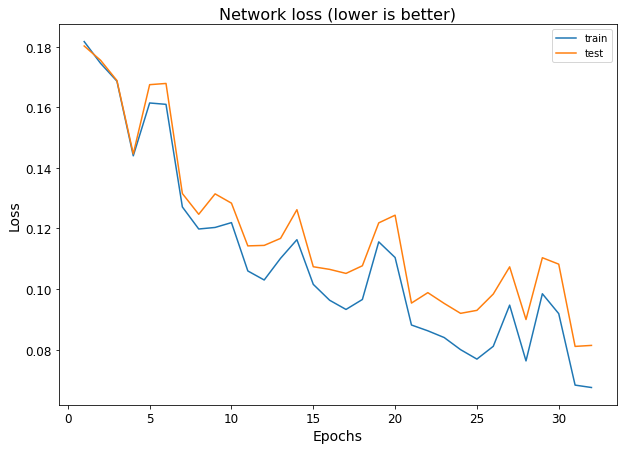

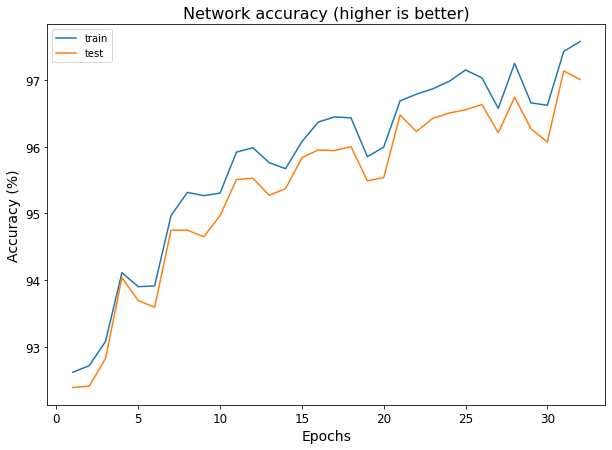

In [ ]:
epochs = np.arange(1, epoch_max + 1)
# plot losses
plt.figure(figsize=(10, 7))
plt.plot(epochs, results["train losses"], label="train")
plt.plot(epochs, results["test losses"], label="test")
plt.title("Network loss (lower is better)", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
# plot accuracies
plt.figure(figsize=(10, 7))
plt.plot(epochs, np.asarray(results["train accuracies"]) * 100, label="train")
plt.plot(epochs, np.asarray(results["test accuracies"]) * 100, label="test")
plt.title("Network accuracy (higher is better)", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
# show plots
plt.show()

In [ ]:
@torch.no_grad()
def display_prediction(network, loader, i=0):
    inputs, labels = next(iter(loader))
    inputs = inputs.to(device)
    labels = labels.to(device)
    network.eval()
    outputs = network(inputs)
    predictions = outputs.argmax(dim=-1)
    plt.figure(figsize=(7, 7))
    plt.axis("off")
    plt.imshow(inputs[i].moveaxis(-3, -1).cpu())
    print(f"Predicted label: {classes[predictions[i].cpu().numpy()]} "
          f"({predictions[i].cpu().numpy()})")
    print(f"Actual label: {classes[labels[i].cpu().numpy()]} ({labels[i].cpu().numpy()})")

Predicted label: non-car (0)
Actual label: non-car (0)


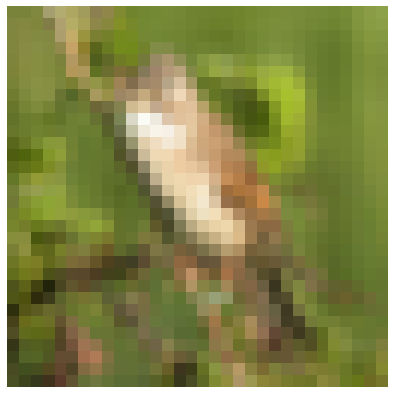

In [ ]:
display_prediction(network, train_loader)

## Saving Weights

Weights saved in order to work across computers.

In [ ]:
# you can put whatever extension you want, .pth (or .pt) is just the PyTorch convention
torch.save(network.state_dict(), "cifar10_model_binary.pth")

## Loading Weights & Evaluate

In [ ]:
network_load = CNN()  # initialize a *new*, untrained network object
network_load.load_state_dict(torch.load("cifar10_model_binary.pth"))  # load our trained weights
network_load.to(device)  # put network on GPU (if it is available)
network_load.eval()

CNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [ ]:
# evaluate our network to make sure we have loaded the weights properly :)
test_loss, test_accuracy = evaluate(test_loader, network_load, criterion)
print(f"Test accuracy: {str(test_accuracy * 100):.6}%   Test loss: {str(test_loss):.6}")

Test accuracy: 73.150%   Test loss: 0.7761
